# En este notebook vamos a realizar un estudio basado en arboles de decisión
## Vamos a realizar el analisis sobre 2 ejes. 
## 1. Categorización
## 2. Regresión

In [2]:
import pandas as pd
import numpy as np

In [3]:
# VARIABLES DEPENDIENTE DEL ENTORNO
user_code = 'u519914'
data_path = '/us/'+user_code+'/lava_iniciative/data/'

# Rutas de ficheros origen
final_dataframe_csv = data_path + 'result/final_dataframe.csv'
select1_dataframe_csv = data_path + 'result/select1_dataframe.csv'

#Rutas de ficheros de salida 
results = data_path + 'result/'
prediction_csv = results + 'DecisionTreePrediction.csv'


In [4]:
#Carga del fichero final CSV
df = pd.read_csv(final_dataframe_csv,sep=";",decimal=",").fillna(0)
print df.shape
#for i in df.columns: print i

(3184, 182)


In [5]:
#Hay un valor que no tiene informado precio.. hay que limpiarlo
df = df[df['precios']!=0]

In [6]:
from sklearn.utils import shuffle
# Mezclamos el orden del dataframe para eliminar situaciones de sesgo a la hora de la eleccion del conjunto de datos de train and test
df = shuffle(df)

In [7]:
def printcolumns(df):
    for i in df.columns: print i

# 1. ESTUDIO SOBRE VARIABLES DE CATEGORIZACION

In [8]:
import sklearn as sk
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Para generación de gráficas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def createDecissionTree(X,y, depth=10, test_size = 0.3, showMetrics = False):
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = test_size)
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    if showMetrics:
        print "train_score: %f" % train_score
        print "test score: %f" % test_score
        #print "cross val(mean): %f" % cross_val_score(clf, X, y, cv=10).mean()
        print sk.metrics.confusion_matrix(y_test, clf.predict(x_test))
    return clf, train_score, test_score

In [10]:
def optimalDepthLine(X, y):
    train_line = []
    test_line = []
    depths = range(1,20)
    for i in depths:
        clf = tree.DecisionTreeClassifier(max_depth=i)
        clf = clf.fit(X, y)
        train_score = clf.score(X, y)
        test_score = cross_val_score(clf, X, y, cv=10).mean()
        train_line += [train_score]
        test_line += [test_score]
        print("%f. train: %f, test: %f" % (i, train_score,test_score))
    plt.plot(depths, train_line)
    plt.plot(depths, test_line)
    plt.legend(['train_score', 'test_score'], loc='upper right')
    plt.show()

In [11]:
# Funcion para presentar las variables de mayor relevancia
def showNFeaturesByImportance(decisor, min_rel):
    
    importances = decisor.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")
    count = 0 
    for f in range(X.shape[1]):
        #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        print("%d. feature %d:%s (%f)" % (f + 1, indices[f],X.columns[indices[f]], importances[indices[f]]))
        if importances[indices[f]] < min_rel: break
        count += 1
    # Presentamos una gráfica con las features más relevantes
    # Plot the feature importances of the forest
    indices = indices[:count]
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(0,count), importances[indices],
           color="r", align="center")
    plt.xticks(range(0,count), indices)
    plt.xlim([-1, count])
    plt.show()

# 1.1. Realizamos una segmentación del precio en 3 niveles

In [103]:
df['precios'].describe()

count    3184.000000
mean     2815.690122
std       974.933258
min       949.039516
25%      2020.890944
50%      2721.074184
75%      3467.563068
max      6693.395712
Name: precios, dtype: float64

### Generamos la variable a precedir en este caso vamos a probar con 25-50-25

In [104]:
y = pd.qcut(df['precios'],[0.,0.25,0.75,1],[0,1,2])
X = df.drop(['precios','nivel_precio'], axis=1)

In [105]:
#printcolumns(X)

1.000000. train: 0.619661, test: 0.616521
2.000000. train: 0.702575, test: 0.677759
3.000000. train: 0.725503, test: 0.703812
4.000000. train: 0.763191, test: 0.724551
5.000000. train: 0.801193, test: 0.743069
6.000000. train: 0.838882, test: 0.749682
7.000000. train: 0.879711, test: 0.752519
8.000000. train: 0.910490, test: 0.758775
9.000000. train: 0.933731, test: 0.754377
10.000000. train: 0.954460, test: 0.755656
11.000000. train: 0.968593, test: 0.751225
12.000000. train: 0.976131, test: 0.747454
13.000000. train: 0.984611, test: 0.738050
14.000000. train: 0.988379, test: 0.739310
15.000000. train: 0.991834, test: 0.734576
16.000000. train: 0.994033, test: 0.735231
17.000000. train: 0.995603, test: 0.738956
18.000000. train: 0.995917, test: 0.729259
19.000000. train: 0.996231, test: 0.724203


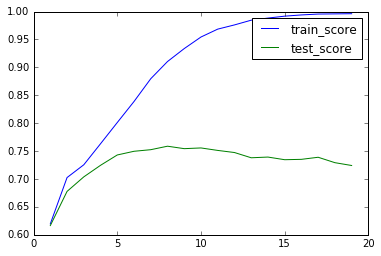

In [106]:
optimalDepthLine(X,y)

Realizando una análisis en base arboles de diferentes profundidades, Observamos:

1. Que la profundidad optima es 6 (0.748)
2. Que a partir del 7 variables el modelo claramente cae en una situación de overfitting
3. Que los arboles con suficiente profundidad se ajustan perfectamente a los datos de entrenamiento
4. Que el tamaño optimo parece estar en 5 niveles

In [107]:
# Revisamos los valores analizados por el árbol para ver si tienen sentido

train_score: 0.801616
test score: 0.730126
[[175  46   3]
 [ 46 356 102]
 [  0  61 167]]
Feature ranking:
1. feature 179:CBD_min (0.401657)
2. feature 176:CBD1 (0.145540)
3. feature 116:estudios_segundo_grado_perc (0.077549)
4. feature 114:sin_estudios_perc (0.070849)
5. feature 177:CBD2 (0.067750)
6. feature 157:es_barsandrestaurants_imp (0.041436)
7. feature 61:2km_hoteles (0.022433)
8. feature 126:viviendas_menos_105m2_perc (0.020511)
9. feature 81:2km_EDUCACION (0.015763)
10. feature 25:1km_hoteles (0.014533)
11. feature 115:estudios_primer_grado_perc (0.014088)
12. feature 59:2km_guarderias (0.013377)
13. feature 146:es_hyper (0.012745)
14. feature 82:2km_CULTURA (0.012588)
15. feature 55:2km_bomberos (0.012414)
16. feature 111:edad_64_anos_perc (0.009864)


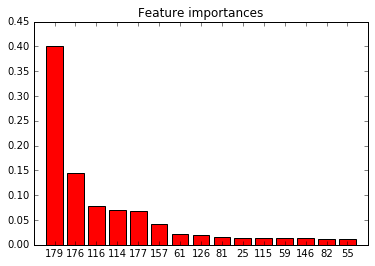

In [113]:
# Comprobamos con profundidad óptima
classif, train_score, test_score = createDecissionTree(X,y, depth=5, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

NO TIENE NINGUN SENTIDO QUE EN MODELOS QUE CONTAMPLAN VARIAS CIUDADES SALGA DISTANCIAS A CBD's PARTICULARES, ya que el 1 2 3y corresponden a cosas diferentes segun la ciudad. Eliminamos estas variables y repetimos el estudio
Además aparece el id_sscc y eso es por que los valores más bajos se corresponden al centro

In [115]:
#Eliminamos las variables del CBD y repetimos
y = pd.qcut(df['precios'],[0.,0.25,0.75,1],[0,1,2])
X = df.drop(['precios','nivel_precio','CBD1','CBD2','CBD3','id_sscc'], axis=1)

1.000000. train: 0.619661, test: 0.618098
2.000000. train: 0.695980, test: 0.676168
3.000000. train: 0.744975, test: 0.712281
4.000000. train: 0.755339, test: 0.730213
5.000000. train: 0.785490, test: 0.735514
6.000000. train: 0.807789, test: 0.726707
7.000000. train: 0.847990, test: 0.735202
8.000000. train: 0.877513, test: 0.731432
9.000000. train: 0.911746, test: 0.727634
10.000000. train: 0.937814, test: 0.723874
11.000000. train: 0.956344, test: 0.721376
12.000000. train: 0.966080, test: 0.723248
13.000000. train: 0.972362, test: 0.716063
14.000000. train: 0.974246, test: 0.707244
15.000000. train: 0.978329, test: 0.713861
16.000000. train: 0.982726, test: 0.717921
17.000000. train: 0.987751, test: 0.704723
18.000000. train: 0.990578, test: 0.713225
19.000000. train: 0.992462, test: 0.705995


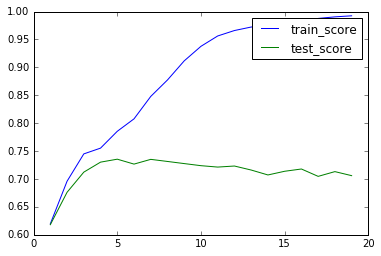

In [116]:
# Volvemos a validar profundidad optima
optimalDepthLine(X,y)

train_score: 0.813285
test score: 0.728033
[[174  50   1]
 [ 39 355  96]
 [  0  74 167]]
Feature ranking:
1. feature 175:CBD_min (0.444462)
2. feature 114:sin_estudios_perc (0.216085)
3. feature 58:2km_farmacias (0.049924)
4. feature 156:es_barsandrestaurants_imp (0.032967)
5. feature 125:viviendas_menos_75m2_perc (0.032262)
6. feature 25:1km_hoteles (0.023396)
7. feature 122:viviendas_alquiler_perc (0.020551)
8. feature 115:estudios_primer_grado_perc (0.020270)
9. feature 111:edad_64_anos_perc (0.019106)
10. feature 131:viviendas_mas_4habitacione_perc (0.015881)
11. feature 34:1km_universidades (0.015435)
12. feature 134:hogares_familias_perc (0.013333)
13. feature 70:2km_universidades (0.012272)
14. feature 30:1km_pistas (0.011689)
15. feature 57:2km_colegios (0.011221)
16. feature 26:1km_monumentos (0.011004)
17. feature 103:500m_SERV_SALUD (0.009745)


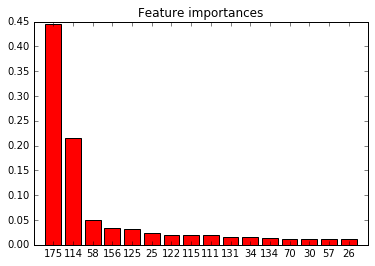

In [117]:
# Comprobamos con profundidad óptima (la mantenemos en 5)
classif, train_score, test_score = createDecissionTree(X,y, depth=5, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

Vamos a probar a predecir con otras categorias de precio

train_score: 0.802513
test score: 0.731172
[[265  58   9]
 [ 27 217  78]
 [  4  81 217]]
Feature ranking:
1. feature 175:CBD_min (0.471504)
2. feature 114:sin_estudios_perc (0.152674)
3. feature 84:2km_TURISMO (0.100319)
4. feature 116:estudios_segundo_grado_perc (0.059421)
5. feature 94:1km_SERV_SALUD (0.039577)
6. feature 156:es_barsandrestaurants_imp (0.029578)
7. feature 108:hombres_perc (0.022785)
8. feature 126:viviendas_menos_105m2_perc (0.018313)
9. feature 127:viviendas_menos_150m2_perc (0.013745)
10. feature 29:1km_piscinas (0.013029)
11. feature 85:2km_SERV_SALUD (0.010601)
12. feature 161:es_health_imp (0.010569)
13. feature 64:2km_parques (0.010369)
14. feature 120:viviendas_vacias_perc (0.010319)
15. feature 122:viviendas_alquiler_perc (0.009621)


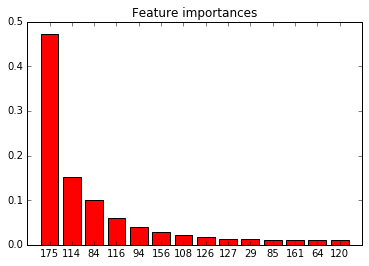

In [121]:
y = pd.qcut(df['precios'],3,[0,1,2])
X = df.drop(['precios','nivel_precio','CBD1','CBD2','CBD3','id_sscc'], axis=1)
#optimalDepthLine(X,y)
classif, train_score, test_score = createDecissionTree(X,y, depth=5, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

train_score: 0.791293
test score: 0.610879
[[197  35   7   0]
 [ 51 124  54  19]
 [  8  42 133  50]
 [  0   7  99 130]]
Feature ranking:
1. feature 175:CBD_min (0.317568)
2. feature 114:sin_estudios_perc (0.136194)
3. feature 61:2km_hoteles (0.116965)
4. feature 58:2km_farmacias (0.051120)
5. feature 126:viviendas_menos_105m2_perc (0.022014)
6. feature 57:2km_colegios (0.019476)
7. feature 59:2km_guarderias (0.015909)
8. feature 111:edad_64_anos_perc (0.014860)
9. feature 34:1km_universidades (0.014466)
10. feature 156:es_barsandrestaurants_imp (0.013784)
11. feature 118:viviendas_principales_perc (0.013739)
12. feature 62:2km_monumentos (0.012617)
13. feature 173:Tot_op (0.012504)
14. feature 147:es_otherservices (0.012235)
15. feature 21:1km_colegios (0.011266)
16. feature 64:2km_parques (0.009711)


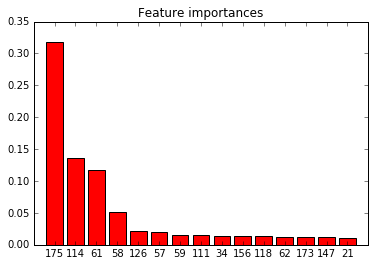

In [125]:
y = pd.qcut(df['precios'],4,[0,1,2,3])
X = df.drop(['precios','nivel_precio','CBD1','CBD2','CBD3','id_sscc'], axis=1)
#optimalDepthLine(X,y)
classif, train_score, test_score = createDecissionTree(X,y, depth=7, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

train_score: 0.742819
test score: 0.539749
[[125  39   4   2   0]
 [ 32 100  57  14   5]
 [  5  23  90  55  13]
 [  0  12  36  99  54]
 [  0   3  16  70 102]]
Feature ranking:
1. feature 175:CBD_min (0.288314)
2. feature 93:1km_TURISMO (0.086397)
3. feature 114:sin_estudios_perc (0.070373)
4. feature 115:estudios_primer_grado_perc (0.038934)
5. feature 58:2km_farmacias (0.028236)
6. feature 35:1km_veterinarios (0.022381)
7. feature 57:2km_colegios (0.022092)
8. feature 174:Tot_imp (0.021498)
9. feature 134:hogares_familias_perc (0.018481)
10. feature 59:2km_guarderias (0.017887)
11. feature 94:1km_SERV_SALUD (0.017630)
12. feature 25:1km_hoteles (0.015601)
13. feature 116:estudios_segundo_grado_perc (0.015066)
14. feature 173:Tot_op (0.014202)
15. feature 21:1km_colegios (0.013003)
16. feature 82:2km_CULTURA (0.012724)
17. feature 64:2km_parques (0.012677)
18. feature 83:2km_DEPORTES (0.012491)
19. feature 125:viviendas_menos_75m2_perc (0.011988)
20. feature 41:500m_guarderias (0.01197

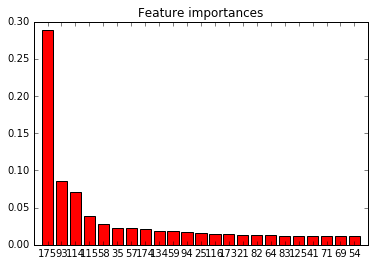

In [124]:
y = pd.qcut(df['precios'],5,[0,1,2,3,4])
X = df.drop(['precios','nivel_precio','CBD1','CBD2','CBD3','id_sscc'], axis=1)
#optimalDepthLine(X,y)
classif, train_score, test_score = createDecissionTree(X,y, depth=7, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

### Las variables se mantienen, pero la predicción empeora

## PROCEDEMOS A REALIZAR UNA ESTIMACION POR SEPARADO (MAD / BAR)

In [126]:
#Eliminamos las variables del CBD
dfM = df[df['provincia']==28]
dfB = df[df['provincia']==8]
yM = pd.qcut(dfM['precios'],[0.,0.25,0.75,1],[0,1,2])
XM = dfM.drop(['precios','nivel_precio','CBD1','CBD2','CBD3','id_sscc'], axis=1)
yB = pd.qcut(dfB['precios'],[0.,0.25,0.75,1],[0,1,2])
XB = dfB.drop(['precios','nivel_precio','CBD1','CBD2','CBD3','id_sscc'], axis=1)

MADRID
1.000000. train: 0.547771, test: 0.537579
2.000000. train: 0.701062, test: 0.679789
3.000000. train: 0.719745, test: 0.697633
4.000000. train: 0.771550, test: 0.728661
5.000000. train: 0.818684, test: 0.737994
6.000000. train: 0.849682, test: 0.745190
7.000000. train: 0.887049, test: 0.757971
8.000000. train: 0.918896, test: 0.747329
9.000000. train: 0.941826, test: 0.747319
10.000000. train: 0.961359, test: 0.753244
11.000000. train: 0.975796, test: 0.744342
12.000000. train: 0.984713, test: 0.744759
13.000000. train: 0.991083, test: 0.739221
14.000000. train: 0.993631, test: 0.741745
15.000000. train: 0.995329, test: 0.725648
16.000000. train: 0.997877, test: 0.740085
17.000000. train: 0.999151, test: 0.735402
18.000000. train: 1.000000, test: 0.733702
19.000000. train: 1.000000, test: 0.732864


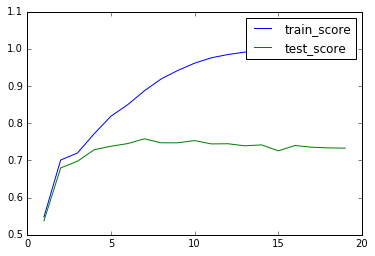

BARCELONA
1.000000. train: 0.499397, test: 0.507789
2.000000. train: 0.597105, test: 0.562108
3.000000. train: 0.632087, test: 0.574022
4.000000. train: 0.686369, test: 0.564192
5.000000. train: 0.752714, test: 0.580370
6.000000. train: 0.803378, test: 0.576362
7.000000. train: 0.863691, test: 0.555860
8.000000. train: 0.910736, test: 0.551951
9.000000. train: 0.942099, test: 0.554523
10.000000. train: 0.963812, test: 0.536477
11.000000. train: 0.984318, test: 0.537933
12.000000. train: 0.991556, test: 0.535346
13.000000. train: 0.992762, test: 0.530554
14.000000. train: 0.997587, test: 0.541603
15.000000. train: 0.998794, test: 0.547324
16.000000. train: 1.000000, test: 0.554814
17.000000. train: 1.000000, test: 0.556991
18.000000. train: 1.000000, test: 0.545130
19.000000. train: 1.000000, test: 0.543852


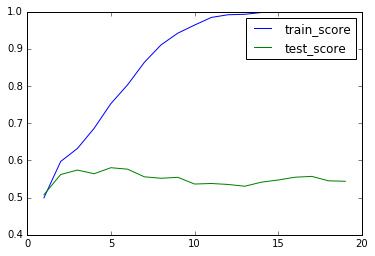

In [127]:
print("MADRID")
optimalDepthLine(XM,yM)
print("BARCELONA")
optimalDepthLine(XB,yB)

train_score: 0.897451
test score: 0.731259
[[141  44   0]
 [ 44 265  45]
 [  0  57 111]]
Feature ranking:
1. feature 175:CBD_min (0.318556)
2. feature 114:sin_estudios_perc (0.138911)
3. feature 156:es_barsandrestaurants_imp (0.127808)
4. feature 112:nacionalidad_espanola_perc (0.028055)
5. feature 39:500m_colegios (0.020525)
6. feature 57:2km_colegios (0.018025)
7. feature 54:2km_bibliotecas (0.017980)
8. feature 29:1km_piscinas (0.017746)
9. feature 103:500m_SERV_SALUD (0.015825)
10. feature 61:2km_hoteles (0.015356)
11. feature 64:2km_parques (0.015342)
12. feature 125:viviendas_menos_75m2_perc (0.013682)
13. feature 40:500m_farmacias (0.012354)
14. feature 23:1km_guarderias (0.012015)
15. feature 126:viviendas_menos_105m2_perc (0.010595)
16. feature 108:hombres_perc (0.010469)
17. feature 83:2km_DEPORTES (0.010086)
18. feature 82:2km_CULTURA (0.009334)


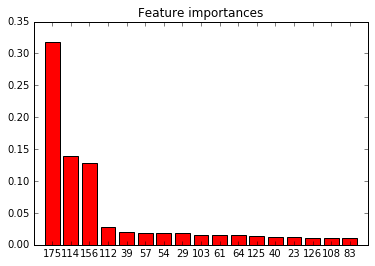

In [128]:
classif, train_score, test_score = createDecissionTree(XM,yM, depth=7, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

train_score: 0.882759
test score: 0.566265
[[30 24  4]
 [19 86 27]
 [ 1 33 25]]
Feature ranking:
1. feature 82:2km_CULTURA (0.166026)
2. feature 34:1km_universidades (0.070972)
3. feature 30:1km_pistas (0.066764)
4. feature 20:1km_cines (0.044013)
5. feature 112:nacionalidad_espanola_perc (0.039258)
6. feature 137:es_barsandrestaurants (0.035796)
7. feature 173:Tot_op (0.034907)
8. feature 122:viviendas_alquiler_perc (0.028626)
9. feature 64:2km_parques (0.028172)
10. feature 85:2km_SERV_SALUD (0.025926)
11. feature 84:2km_TURISMO (0.025784)
12. feature 165:es_leisure_imp (0.021504)
13. feature 119:viviendas_secundarias_perc (0.020686)
14. feature 111:edad_64_anos_perc (0.020537)
15. feature 115:estudios_primer_grado_perc (0.020402)
16. feature 144:es_hotelservices (0.020129)
17. feature 162:es_home_imp (0.019526)
18. feature 124:viviendas_menos_45m2_perc (0.018898)
19. feature 37:500m_bomberos (0.015248)
20. feature 43:500m_hoteles (0.014576)
21. feature 125:viviendas_menos_75m2_perc 

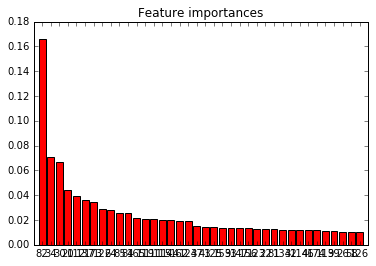

In [129]:
classif, train_score, test_score = createDecissionTree(XB,yB, depth=7, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

### Conclusiones Iniciales:
Madrid se predice mejor con 2 variables
Barcelona se precide peor, el cbd influye menos y entran más variebales relativos a los "elementos cercanos"
Las 2 ciudades no se comportan igual... 
## Pero lo mas relevante.....
Es mejor predecir conjuntamente que por separado. 
¿Habría que ampliar el campo de revisión para mejorar?

## Ejecutamos una predicción con el mejor de los árboles identificado

train_score: 0.809695
test score: 0.719665
[[185  42   1]
 [ 61 358  71]
 [  1  92 145]]
Feature ranking:
1. feature 175:CBD_min (0.433277)
2. feature 114:sin_estudios_perc (0.166827)
3. feature 116:estudios_segundo_grado_perc (0.071288)
4. feature 156:es_barsandrestaurants_imp (0.045937)
5. feature 84:2km_TURISMO (0.042391)
6. feature 58:2km_farmacias (0.022753)
7. feature 34:1km_universidades (0.022210)
8. feature 122:viviendas_alquiler_perc (0.021528)
9. feature 127:viviendas_menos_150m2_perc (0.021466)
10. feature 126:viviendas_menos_105m2_perc (0.019516)
11. feature 109:edad_16anos_perc (0.014391)
12. feature 85:2km_SERV_SALUD (0.014369)
13. feature 62:2km_monumentos (0.013677)
14. feature 28:1km_parques (0.013057)
15. feature 61:2km_hoteles (0.011579)
16. feature 24:1km_hospitales (0.010091)
17. feature 112:nacionalidad_espanola_perc (0.009686)


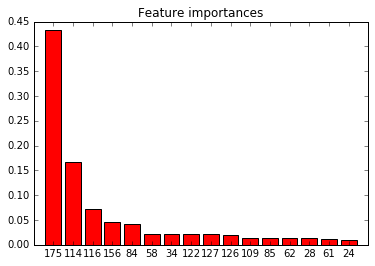

In [130]:
#Eliminamos las variables del CBD
y = pd.qcut(df['precios'],[0.,0.25,0.75,1],[0,1,2])
X = df.drop(['precios','nivel_precio','CBD1','CBD2','CBD3','id_sscc'], axis=1)
classif, train_score, test_score = createDecissionTree(X,y, depth=5, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

In [131]:
#help(clf.predict)
p = classif.predict(X)

In [134]:
df_csv = df
df_csv['nivel_precio'] = y
df_csv['prediction'] = p
df_csv['acierto'] = df_csv['prediction'] == y
#df_final['id_sscc'] = df_final['id_sscc'].apply(lambda x: "%010d" % + x)
print df_csv.shape
df_csv.to_csv(prediction_csv)

(3184, 185)


In [137]:
sk.tree.export_graphviz(classif,results+'DecisionTree.dot', feature_names=X.columns)


In [148]:
from StringIO import StringIO
out = StringIO()
tree.export_graphviz(classif, out_file=out, feature_names=X.columns)
print out.getvalue()

digraph Tree {
node [shape=box] ;
0 [label="CBD_min <= 6011.6738\ngini = 0.6276\nsamples = 2228\nvalue = [568, 1102, 558]"] ;
1 [label="sin_estudios_perc <= 0.0414\ngini = 0.5166\nsamples = 1518\nvalue = [70, 898, 550]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="es_barsandrestaurants_imp <= 31360.1699\ngini = 0.4928\nsamples = 693\nvalue = [6, 282, 405]"] ;
1 -> 2 ;
3 [label="viviendas_menos_150m2_perc <= 0.066\ngini = 0.4913\nsamples = 255\nvalue = [5, 155, 95]"] ;
2 -> 3 ;
4 [label="1km_universidades <= 4.0\ngini = 0.4248\nsamples = 187\nvalue = [5, 133, 49]"] ;
3 -> 4 ;
5 [label="gini = 0.3816\nsamples = 172\nvalue = [5, 130, 37]"] ;
4 -> 5 ;
6 [label="gini = 0.32\nsamples = 15\nvalue = [0, 3, 12]"] ;
4 -> 6 ;
7 [label="CBD_min <= 4650.7988\ngini = 0.4377\nsamples = 68\nvalue = [0, 22, 46]"] ;
3 -> 7 ;
8 [label="gini = 0.3457\nsamples = 54\nvalue = [0, 12, 42]"] ;
7 -> 8 ;
9 [label="gini = 0.4082\nsamples = 14\nvalue = [0, 10, 4]"] ;
7 -> 9 ;
10 [labe

VISUALIZADOR:
http://dreampuf.github.io/GraphvizOnline/

# REPETIMOS LA OPERACION CON LA SELECCION DE VARIABLES

In [12]:
#Carga del fichero con las variables pre-seleccionadas
df = pd.read_csv(select1_dataframe_csv,sep=";",decimal=".").fillna(0)
print df.shape
#for i in df.columns: print i

(3184, 100)


In [13]:
from sklearn.utils import shuffle
df = df[df['precios']!=0]
# Mezclamos el orden del dataframe para eliminar situaciones de sesgo a la hora de la eleccion del conjunto de datos de train and test
df = shuffle(df)

In [14]:
df.describe()

id_sscc  edad_16anos_perc  edad_64_anos_perc  \
count  3.184000e+03       3184.000000        3184.000000   
mean   2.285618e+09          0.127574           0.219863   
std    8.804401e+08          0.058579           0.089294   
min    8.019010e+08          0.000000           0.000000   
25%    8.019101e+08          0.087379           0.159603   
50%    2.807907e+09          0.121476           0.215027   
75%    2.807913e+09          0.158829           0.273302   
max    2.807921e+09          0.379475           0.617512   

       nacionalidad_extranjera_perc  casados_perc  sin_estudios_perc  \
count                   3184.000000   3184.000000        3184.000000   
mean                       0.145741      0.412401           0.072849   
std                        0.120672      0.081146           0.059155   
min                        0.000000      0.092251           0.000000   
25%                        0.056511      0.362012           0.027992   
50%                        0.114979      0.416404           0.059063   
75%                        0.207061      0.467134           0.103681   
max                        0.736842      0.675258           0.380952   

       estudios_primer_grado_perc  estudios_segundo_grado_perc  \
count                 3184.000000                  3184.000000   
mean                     0.107125                     0.419608   
std                      0.060350                     0.099567   
min                      0.000000                     0.090692   
25%                      0.062500                     0.353450   
50%                      0.098540                     0.423297   
75%                      0.142857                     0.487854   
max                      0.455959                     0.750000   

       estudios_tercer_grado_perc  viviendas_principales_perc     ...       \
count                 3184.000000                 3184.000000     ...        
mean                     0.272356                    0.863758     ...        
std                      0.154430                    0.114911     ...        
min                      0.000000                    0.000000     ...        
25%                      0.142415                    0.800000     ...        
50%                      0.255894                    0.882353     ...        
75%                      0.396226                    0.954023     ...        
max                      0.730769                    1.000000     ...        

       es_otherservices_count  es_propertyservices_count  \
count             3184.000000                3184.000000   
mean               182.450691                   4.653580   
std                175.572545                   7.386313   
min                  0.000000                   0.000000   
25%                 56.000000                   0.000000   
50%                115.000000                   2.000000   
75%                249.250000                   6.000000   
max                932.000000                  60.000000   

       es_sportsandtoys_count  es_tech_count  es_transportation_count  \
count             3184.000000    3184.000000              3184.000000   
mean                33.902638      68.170226               153.226131   
std                 28.628224      53.897145                68.571134   
min                  0.000000       0.000000                 1.000000   
25%                 11.000000      24.000000               109.000000   
50%                 25.000000      54.000000               150.500000   
75%                 52.000000     100.000000               196.000000   
max                129.000000     270.000000               449.000000   

       es_travel_count  es_wellnessandbeauty_count         CUSEC  \
count      3184.000000                 3184.000000  3.184000e+03   
mean         27.742148                  142.259108  2.285618e+09   
std          32.049283                  120.724953  8.804401e+08   
min           0.000000                    0.000000  8

In [15]:
y = pd.qcut(df['precios'],[0.,0.25,0.75,1],[0,1,2])
X = df.drop(['precios','CBD1','CBD2','CBD3','id_sscc'], axis=1)

1.000000. train: 0.619661, test: 0.617807
2.000000. train: 0.744975, test: 0.735856
3.000000. train: 0.757224, test: 0.745588
4.000000. train: 0.790829, test: 0.765705
5.000000. train: 0.814384, test: 0.775777
6.000000. train: 0.837312, test: 0.776379
7.000000. train: 0.870289, test: 0.782370
8.000000. train: 0.899183, test: 0.781403
9.000000. train: 0.924309, test: 0.777002
10.000000. train: 0.943467, test: 0.766299
11.000000. train: 0.959799, test: 0.760998
12.000000. train: 0.972362, test: 0.766332
13.000000. train: 0.982098, test: 0.761626
14.000000. train: 0.987437, test: 0.763795
15.000000. train: 0.989950, test: 0.766638
16.000000. train: 0.993090, test: 0.756251
17.000000. train: 0.995603, test: 0.755341
18.000000. train: 0.996859, test: 0.753445
19.000000. train: 0.998744, test: 0.760056


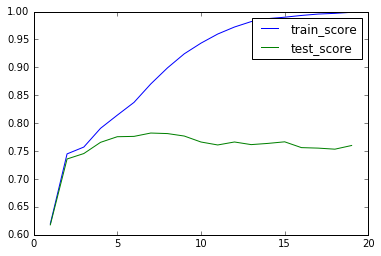

train_score: 0.828097
test score: 0.781381
[[196  28   1]
 [ 47 397  49]
 [  0  84 154]]
Feature ranking:
1. feature 52:CBD_min (0.354675)
2. feature 7:estudios_tercer_grado_perc (0.329176)
3. feature 80:es_health_count (0.049133)
4. feature 91:es_wellnessandbeauty_count (0.048624)
5. feature 89:es_transportation_count (0.038089)
6. feature 62:es_home (0.029330)
7. feature 24:hogares_familias_perc (0.023488)
8. feature 73:es_auto_count (0.020560)
9. feature 58:es_contents (0.014369)
10. feature 32:2km_hoteles (0.013731)
11. feature 6:estudios_segundo_grado_perc (0.012667)
12. feature 63:es_hotelservices (0.010008)
13. feature 61:es_health (0.008481)


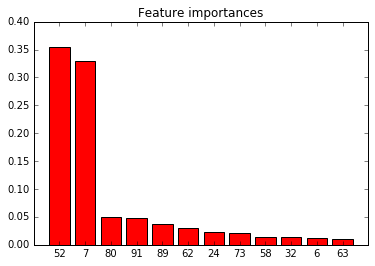

In [16]:
optimalDepthLine(X,y)
classif, train_score, test_score = createDecissionTree(X,y, depth=7, test_size = 0.3, showMetrics = True)
showNFeaturesByImportance(classif, 0.01)

In [23]:
classif, train_score, test_score = createDecissionTree(X,y, depth=7, test_size = 0.3, showMetrics = True)

train_score: 0.881957
test score: 0.758368
[[172  44   0]
 [ 48 390  72]
 [  1  66 163]]


# Con la agregacion de importes propuesta, aparecen como significativas las operaciones en transportes y centros de belleza

In [60]:
# TO-DO SACAR EL ARBOL Y PINTARLO


In [62]:
df_csv = df

df_csv['nivel_precio'] = y
df_csv['prediction'] = classif.predict(X)
proba = classif.predict_proba(X)
df_csv['proba_0'] = proba[:,0]
df_csv['proba_1'] = proba[:,1]
df_csv['proba_2'] = proba[:,2]
df_csv['acierto'] = df_csv['prediction'] == y
#df_csv['id_sscc'] = df_csv['id_sscc'].apply(lambda x: "%010d" % + x)

print df_csv.shape
df_csv.to_csv(prediction_csv)
print prediction_csv

(3184, 106)
/us/u519914/lava_iniciative/data/result/DecisionTreePrediction.csv


### Por último, vamos a realizar la predicción con todos los datos del Ine, incluidos los que no tenemos precio y lo volcamos en CSV que llamaremos  "_full"

In [64]:
df_full = pd.read_csv(results + "sscc_no_madiva.csv",sep=";",decimal=",", index_col=False).fillna(0)
df_full.head(5)

Unnamed: 0  hombres_perc    id_sscc  edad_16anos_perc_x  \
0           3      0.486911  801901004            0.164921   
1           9      0.559715  801901010            0.203209   
2          11      0.542373  801901012            0.152542   
3          14      0.537288  801901015            0.208475   
4          15      0.600000  801901016            0.119266   

   edad_64_anos_perc_x  nacionalidad_extranjera_perc_x  casados_perc_x  \
0             0.136126                        0.175393        0.321990   
1             0.073084                        0.677362        0.459893   
2             0.156780                        0.364407        0.398305   
3             0.130508                        0.491525        0.347458   
4             0.071560                        0.710092        0.477064   

   sin_estudios_perc_x  estudios_primer_grado_perc_x  \
0             0.078534                      0.094241   
1             0.171123                      0.117647   
2             0.072034                      0.101695   
3             0.055932                      0.132203   
4             0.097248                      0.036697   

   estudios_segundo_grado_perc_x           ...             \
0                       0.298429           ...              
1                       0.367201           ...              
2                       0.411017           ...              
3                       0.396610           ...              
4                       0.669725           ...              

   viviendas_menos_75m2_perc_x  viviendas_menos_105m2_perc_x  \
0                     0.527778                      0.233333   
1                     0.591133                      0.000000   
2                     0.694915                      0.000000   
3                     0.544643                      0.165179   
4                     0.000000                      0.000000   

   viviendas_menos_150m2_perc_x  viviendas_mas_150m2_perc_x  \
0                      0.033333                         0.0   
1                      0.000000                         0.0   
2                      0.000000                         0.0   
3                      0.040179                         0.0   
4                      0.000000                         0.0   

   viviendas_menos_2habitaciones_perc_x  viviendas_menos_4habitaciones_perc_x  \
0                              0.222222                              0.494444   
1                              0.000000                              0.630542   
2                              0.000000                              0.550847   
3                              0.133929                              0.616071   
4                              0.000000                              0.430168   

   viviendas_mas_4habitacione_perc_x  hogares_unifamiliares_perc_x  \
0                           0.283333                      0.294444   
1                           0.000000                      0.251232   
2                           0.000000                      0.457627   
3                           0.254464                      0.321429   
4                           0.000000                      0.156425   

   hogares_parejas_perc_x  hogares_familias_perc_x  
0                0.438889                 0.266667  
1                0.295567                 0.463054  
2                0.296610                 0.237288  
3                0.209821                 0.473214  
4                0.385475                 0.463687  

[5 rows x 28 columns]